# Start simple, Start linearly

The program below will mark the first RL algorithm truly implemented in this project. As such, to see if I've got the basics down, I started with a simply linear policy to learn. The algorithm contains two main parts. 

* The first is to learn a surrogate dynamics model of the environment. I personally like to think of this as the agent's belief of how the environment behaves, so the term surrogate doesn't too appropriate. A GP model will be used, with a gaussian covariance kernel. 

* The second is to use this belief of the system to learn an optimal policy. As mentioned previously, a linear policy structure will be used. Furthermore, bayesian optimisation with expected improvement will be used to find the optimal policy values. 

Let's see how this goes. Fingers crossed. 

In [1]:
%matplotlib inline

import gym
import GPy
import GPyOpt
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import gympy



Once the libraries have been imported as above, the openai gym environment and the appropriate covariance kernels will need to be defined. The former of these can be carried out using the *setupEnvironment* function in the gympy library. This outputs the relevant input and observations arrays, as well as the rewards, action and prediction initial arrays. 

In [20]:
env, observations, inputsNumpy, observationsNumpy, rewardsNumpy, action, predictionPDF = gympy.setupEnvironment(defaultEnvironment = 'Pendulum-v0', whichVersion = 0)
k_dynamics = GPy.kern.RBF(input_dim=4, variance=1., lengthscale=1.)
k_rewards = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=1.)

Please enter the environment: 


[2016-11-24 19:11:23,610] Making new env: Pendulum-v0


It is now necessary to define the key features of the RL algorithm. These include the how the reward (or cost) will be caluculated, the structure of the policy, and finally the objective function that will be minimised. 

The first of these is how the reward will be calculated. The reward, as mentioned in the [previous notebook](Learning_3.ipynb), the reward is function of the current state and the goal state. For the present notebook, the reward is calculated as the sum of the geometric distances between the each of the current states and the goal states. Please note that since each of these will be $ \geqslant \: 0$, it is technically speaking a cost, rather than a reward. However, since the difference betweeen the two is merely a negative symbol, reward and cost will be used interchangebly. 

Since the present problem will use a linear policy, which is only applicable to a pendulum at very small angles away from equilibrium points, the agent will be punished for moving away by $1^0$ from the equilibrium angle.

In [3]:
def generateTotalReward(predictionPDF, goalState, totalReward):
    predictionPDF[0,2] = predictionPDF[0,1]/8
    if (abs(predictionPDF[0,0]) < np.cos(5*np.pi/180)) or (abs(predictionPDF[0,1]) > np.sin(5*np.pi/180)):
        multiplier = 1000
    else:
        multiplier = 1
    currentReward = multiplier*(np.sqrt(np.sum((predictionPDF-goalState)*(predictionPDF-goalState))))
    totalReward = totalReward + currentReward
    
    return totalReward

The policy must now be defined in terms of its parameters. In this particular example, a linear policy was chosen, for simplicity. This will be of the form:

$$ \pi(s_t) = \phi(s_t)^T \mathbf{\theta} + \mathbf{b},$$

where the basis functions in $\phi$ are simply the state variables, and the vector $\theta$ represents the weights. Thus the action will be selected by policy that looks like:

$$ a_t = s_{t,1}\theta_1 + s_{t,2}\theta_2  +  s_{t,3}\theta_3 + \theta_4, $$

since this particular problem has 3 state variables. Note that $\theta_4$ is the sum of the vector $\mathbf{b}$. The reinforcement learning problem now becomes one of finiding the values of $\theta$ such that the cost defined earlier is minimised. 

A function is defined to return the action after following the equation above.

In [4]:
def action_fromPolicy(policyParameters, bufferObservations_policy):
    actionToTake_policy = 0
    [r,c] = policyParameters.shape
    for i in range(c):
        if i < c-1:
            actionToTake_policy = actionToTake_policy + (bufferObservations_policy[0,i] * policyParameters[0,i])
        else:
            actionToTake_policy = actionToTake_policy + policyParameters[0,i]
    actionToTake_policy = 2 * ((9/8)*np.sin(actionToTake_policy) + (1/8)*np.sin(3*actionToTake_policy))         

    return actionToTake_policy

Finding the policy parameters that minimise the total reward is clearly an optimisation problem. As such the optimisation method that will be used for this particular notebook is Bayesian Optimisation using Expected Improvement. Simply put, this methods chooses the next test point based on the highest expected improvement from the current minimun point (for a minimising problem that is). Thusly, a good mix of exploration and exploitation can be utilised to find the global minimum given the state box.

The python library GPyOpt will be utilised for this. This requires the definition of an objective function; this is function that is to be optimised. In the present work, this will be the mapping from the policyy parameters to the total reward. Since this is a model based RL algorithm, the GP model that was trained previously will be used to generate the total reward. 

In [6]:
def objectiveFunction(policyParameters):
    thetaBound = np.array([np.pi*5*180,1])
    thetaObservations = np.random.uniform(low=-thetaBound, high=thetaBound)

    bufferObservations_policy = np.array([np.cos(thetaObservations[0]), np.sin(thetaObservations[0]), thetaObservations[1]])

    bufferObservations_policy = np.reshape(bufferObservations_policy, ([1,3]))
    bufferInputs_policy = np.zeros((1,4))
    
    totalIterations = 1000
    totalReward = 0
    
    goalState = np.array([1,0,0])

    
    actionToTake_policy = action_fromPolicy(policyParameters, bufferObservations_policy)
    predictionPDF = bufferObservations_policy
    
    attempt = 1
    for i in range(totalIterations):
        
#         if abs(actionToTake_policy) > 2:
#             totalReward = totalReward + 1000
        bufferActionToTake = np.array([actionToTake_policy])
        bufferActionToTake = np.reshape(bufferActionToTake, ([1]))
        bufferACtionToTake_toAppend = np.reshape(bufferActionToTake,([1,1]))
        bufferInputs_policy = np.append(bufferActionToTake_toAppend, predictionPDF, axis = 1) 

#         predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
        
        predictionPDF, rewards, done, info = env.step(bufferActionToTake)
        predictionPDF_actual = np.reshape(predictionPDF, ([1,3]))
        predctionPDF_emulation = m_dynamics.predict(bufferInputs_policy)[0]
        
#         inputsNumpy, bufferInput = gympy.appendInputArray(inputsNumpy, bufferActionToTake_toAppend, predictionPDF, attempt)
#         [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations, attempt)
        
        totalReward = generateTotalReward(predictionPDF_actual, goalState, totalReward)
        actionToTake_policy = action_fromPolicy(policyParameters, predictionPDF)
        
        
        
#         env.setState(np.arccos(predictionPDF[0,0]), predictionPDF[0,2])
#         env.render()
#         if (abs(predictionPDF_actual[0,0]) < np.cos(5*np.pi/180)):
#             break

        

#     m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
#     m_dynamics.optimize()


        
        
    return totalReward

def objectiveFunction_iterations(policyParameters):
    thetaBound = np.array([np.pi*5*180,1])
    thetaObservations = np.random.uniform(low=-thetaBound, high=thetaBound)

    bufferObservations_policy = np.array([np.cos(thetaObservations[0]), np.sin(thetaObservations[0]), thetaObservations[1]])

    bufferObservations_policy = np.reshape(bufferObservations_policy, ([1,3]))
    bufferInputs_policy = np.zeros((1,4))
    
    totalIterations = 1000
    totalReward = 0
    counter = 1
    
    predictionPDF = env.reset(whichVersion=1)
    predictionPDF = np.reshape(predictionPDF, ([1,3]))
    actionToTake_policy = action_fromPolicy(policyParameters, predictionPDF)
    
    
    
    while abs(predictionPDF[0,0]) > np.cos(5*np.pi/180) and counter <= totalIterations:
                
        bufferActionToTake = np.array([actionToTake_policy])
        bufferActionToTake = np.reshape(bufferActionToTake, ([1]))
#         bufferActionToTake_toAppend = np.reshape(bufferActionToTake,([1,1]))
#         bufferInputs_policy = np.append(bufferActionToTake_toAppend, predictionPDF, axis = 1) 
        
        predictionPDF, rewards, done, info = env.step(bufferActionToTake)
        predictionPDF = np.reshape(predictionPDF, ([1,3]))
        actionToTake_policy = action_fromPolicy(policyParameters,predictionPDF)
        
        counter += 1
    
    
    totalReward = 1000/counter
    
    return totalReward
        
    

A random policy is now created to start the process.

In [7]:
policyBounds = np.array([1,1,1,10])
policyParameters =  np.random.uniform(low = -policyBounds, high = policyBounds)
policyParameters = np.reshape(policyParameters,([1,4]))

What follows now will be the RL loop. However, in order to explain the steps using markdown the first iteration will be carried out outside the loop. The remaining steps will be carried out within a loop without any remarks.

Once the policy parameters have been chosen, they must be used on the actual system.

In [9]:
for attempt in range(1000):
    if attempt%200 == 0:
        observations = env.reset(whichVersion=0)
        
    bufferObservations = np.reshape(observations, ([1,3]))
    actionToTake = action_fromPolicy(policyParameters, bufferObservations)
    actionToTake_random = env.action_space.sample()
    
    inputsNumpy, bufferInput = gympy.appendInputArray(inputsNumpy, actionToTake_random, observations, attempt)
    
    actionToTake = np.array([actionToTake])
    
    [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations, attempt)
    
    observations, rewards, done, info = env.step(actionToTake_random)
    
    env.render()

Using the data points that were recorded from this trial, the system will learn a model of how the environment behaves.

In [10]:
m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
m_dynamics.optimize()

[2016-11-24 19:00:12,995] initializing Y
[2016-11-24 19:00:12,997] initializing inference method
[2016-11-24 19:00:12,998] adding kernel and likelihood as parameters


[[ 0.47058699  0.15016868  0.85939597 -4.57000853]]


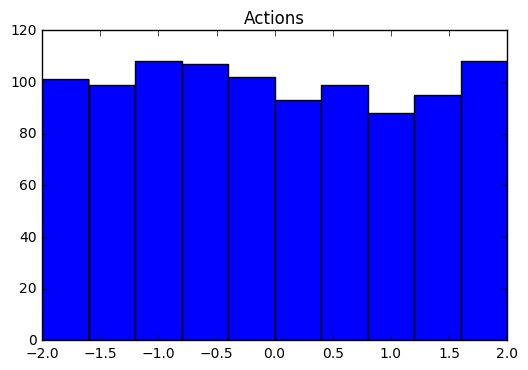

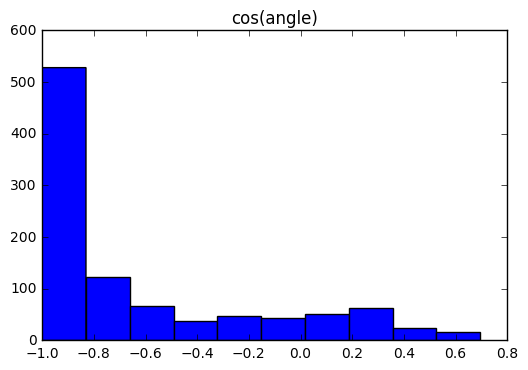

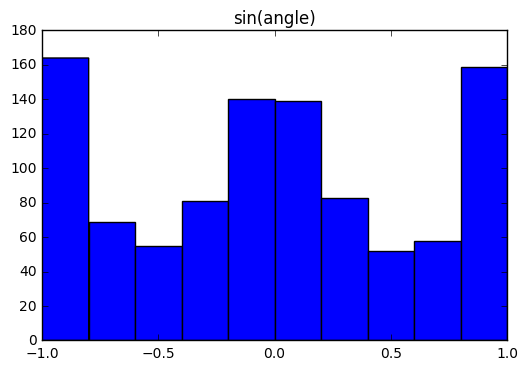

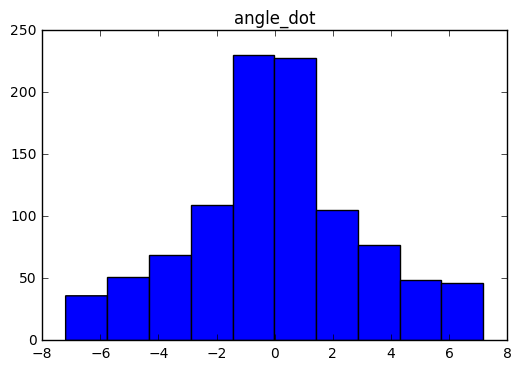

In [11]:
plt.figure()
plt.hist(inputsNumpy[:,0])
plt.title('Actions')

plt.figure()
plt.hist(inputsNumpy[:,1])
plt.title('cos(angle)')

plt.figure()
plt.hist(inputsNumpy[:,2])
plt.title('sin(angle)')

plt.figure()
plt.hist(inputsNumpy[:,3])
print policyParameters
plt.title('angle_dot')


Now the agent will attempt to optimise the parameters of the policy using this learned model as its belief of how the environment behave.

In [12]:
bounds = [{'domain': (-1,1), 'name': 'var_1', 'type': 'continuous', 'dimensionality':3},
         {'domain': (-10,10), 'name': 'var_4', 'type': 'continuous', 'dimensionality':1}]

In [13]:
myBopt = GPyOpt.methods.BayesianOptimization(f = objectiveFunction_iterations, domain = bounds, acquisition_type ='MPI', num_cores=4, verbosity=True)
max_iter = 400              # evaluation budget
myBopt.run_optimization(max_iter)   # run optimization
print min(myBopt.Y)
print myBopt.Y.shape

[2016-11-24 19:00:48,883] initializing Y
[2016-11-24 19:00:48,885] initializing inference method
[2016-11-24 19:00:48,886] adding kernel and likelihood as parameters


[ 24.]
(405, 1)


In [ ]:
max_iter = 100              # evaluation budget
myBopt.run_optimization(max_iter)   # run optimization
print min(myBopt.Y)
print myBopt.Y.shape

Now the policy that produced to smallest long term cost, will be chosen, and will be used on the environment once more, which will then generate more data that will be added to the dynamics model to be optimised again. As such, the loop continues.

In [24]:
policyParameters = myBopt.X[np.argmin(myBopt.Y)]
print min(myBopt.Y)
policyParameters = np.reshape(policyParameters, ([1,4]))
print policyParameters 

# thetaBound = np.array([np.pi*5*180,1])

# thetaObservations = np.random.uniform(low=-thetaBound, high=thetaBound)

# bufferObservations_policy = np.array([np.cos(thetaObservations[0]), np.sin(thetaObservations[0]), thetaObservations[1]])

# bufferObservations_policy = np.reshape(bufferObservations_policy, ([1,3]))
# actionBuffer = action_fromPolicy(policyParameters, bufferObservations_policy)

# predictionPDF = bufferObservations_policy
# print predictionPDF
# env.setState(np.arccos(predictionPDF[0,0]),predictionPDF[0,2]) 
# for i in range(100):
#     bufferActionToTake = np.array([actionBuffer])
#     bufferActionToTake = np.reshape(bufferActionToTake, ([1,1]))
#     bufferInputs_policy = np.append(bufferActionToTake, predictionPDF,axis = 1)
    
#     predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
    
#     actionToTake_policy = action_fromPolicy(policyParameters, predictionPDF)
    
#     print predictionPDF

[ 24.]
[[  0.55944201   0.80162202   0.4665589  -10.        ]]


In [ ]:
for iterations in range(5):
    observations = env.reset(whichVersion = 1)
    for attempt in range(201):
        attempt = attempt + 1
        bufferObservations = np.reshape(observations, ([1,3]))
        actionToTake = action_fromPolicy(policyParameters, bufferObservations)

        inputsNumpy, bufferInput = gympy.appendInputArray(inputsNumpy, actionToTake, observations, attempt)
        actionToTake = np.array([actionToTake])

        [observationsNumpy, bufferObservations] = gympy.appendObservationsArray(observationsNumpy, observations, attempt)

        observations, rewards, done, info = env.step(actionToTake)

        env.render()
        
    m_dynamics = gympy.generateModel(inputsNumpy, observationsNumpy, k_dynamics)
    m_dynamics.optimize()
    
    
    initialX = np.reshape(policyParameters, ([4,1]))
#     print initialX
    myBopt = GPyOpt.methods.BayesianOptimization(f = objectiveFunction, domain = bounds, acquisition_type ='MPI', num_cores=4)
    max_iter = 200              # evaluation budget
    myBopt.run_optimization(max_iter)   # run optimization
    print myBopt.Y.shape
    print min(myBopt.Y)
    
    policyParameters = myBopt.X[np.argmin(myBopt.Y)]
    policyParameters = np.reshape(policyParameters, ([1,4])) 
    print policyParameters

In [25]:
observations = env.reset(whichVersion = 1)
predictionPDF = np.reshape(observations, ([1,3]))
print policyParameters

# policyParameters = np.array([ 0.00875598,  0.25458643, -0.95027489,  6.63289069])
# policyParameters = np.reshape(policyParameters, ([1,4]))
# # observations = env.state(inputTheta = initialStates[0,0], inputThetaDot = initialStates[0.1])
for i in range (100):
    env.render()
    observations = np.reshape(observations, ([1,3]))
    action = action_fromPolicy(policyParameters, observations)
    action = np.array([action])
    
    bufferActionToTake = np.reshape(action, ([1,1]))
    bufferInputs_policy = np.append(bufferActionToTake, predictionPDF, axis = 1) 
    
    print action, observations-predictionPDF
    
#     predictionPDF = m_dynamics.predict(bufferInputs_policy)[0]
    observations, rewards, done, info = env.step(action)

[[  0.55944201   0.80162202   0.4665589  -10.        ]]
[ 0.04181514] [[ 0.  0.  0.]]
[ 0.04031105] [[  4.71002958e-07   7.42068562e-05   1.48416702e-03]]
[ 0.03885973] [[  1.34409266e-06   2.14122959e-04   2.79837655e-03]]
[ 0.03741691] [[  2.55804362e-06   4.14110499e-04   3.99982449e-03]]
[ 0.03594476] [[  4.05784287e-06   6.70848143e-04   5.13484051e-03]]
[ 0.03441] [[  5.79214680e-06   9.82922707e-04   6.24158769e-03]]
[ 0.03278242] [[  7.71011404e-06   1.35052654e-03   7.35217677e-03]]
[ 0.03103367] [[  9.75778106e-06   1.77523815e-03   8.49433092e-03]]
[ 0.02913631] [[  1.18739821e-05   2.25986884e-03   9.69270640e-03]]
[ 0.02706296] [[  1.39857099e-05   2.80836232e-03   1.09699509e-02]]
[ 0.02478562] [[  1.60027389e-05   3.42573719e-03   1.23475636e-02]]
[ 0.02227502] [[  1.78112696e-05   4.11806511e-03   1.38466060e-02]]
[ 0.01950007] [[  1.92662919e-05   4.89247892e-03   1.54883038e-02]]
[ 0.01642734] [[  2.01822945e-05   5.75720690e-03   1.72945698e-02]]
[ 0.01302052] [[  2.